In this study, I directly apply Principal Component Analysis (PCA) to stock return series without first calculating the covariance matrix. Although this approach may introduce some noise, it enables PCA to capture the temporal information inherent in the data, unlike the traditional method that relies on the covariance matrix and only provides static information. Further improvements and variations of PCA will be discussed in the "Discussion and Limitations" section.


**Outline:**
* Apply PCA to asset returns to identify major risks/forces/factors
* Reconstruct components/factors porfolio based on components' loadings
* Construct Portfolios through PCA filtering
* Backtesting PCA suggested portfolios
* Dicussion and Limitations

# Principal Component Analysis (PCA)

## Import Packages

In [ ]:
#! pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import bs4 as bs
import requests
import seaborn as sns
from sklearn.decomposition import PCA

## Conduct a simple EDA

In [ ]:
plt.style.use('bmh')

In [ ]:
# Scrap sp500 tickers
def save_sp500_tickers():

    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'html')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        if not '.' in ticker:
            tickers.append(ticker.replace('\n',''))

    return tickers

tickers = save_sp500_tickers()

In [ ]:
# Download the stocks data through yahoo finance API
prices = yf.download(tickers, start='2020-01-01')['Adj Close']

[*********************100%%**********************]  501 of 501 completed


In [ ]:
# Calculate the return
rs = prices.apply(np.log).diff(1)

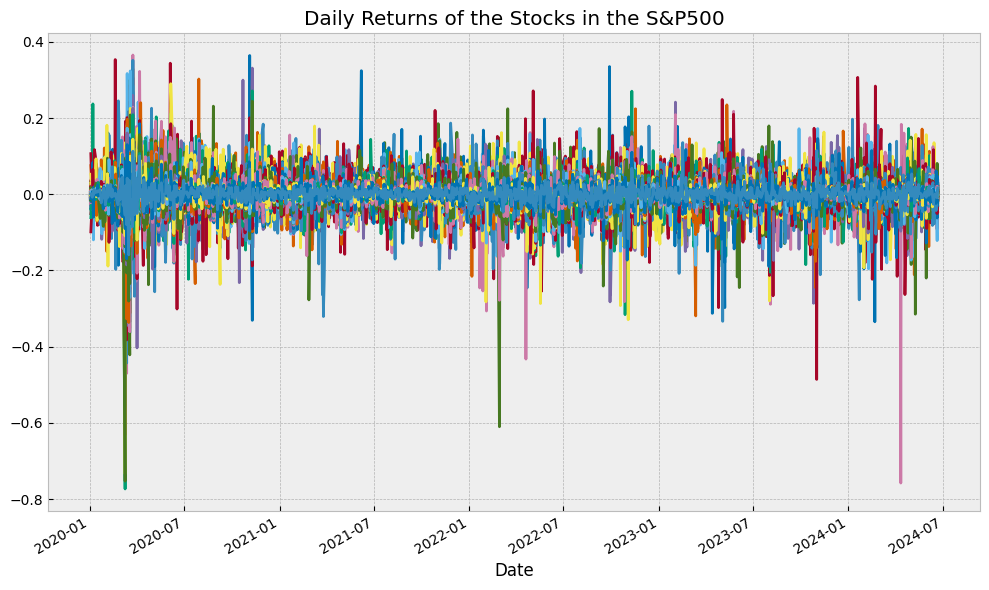

In [ ]:
# Plot the return of the stocks in S&P 500 to get a glimpse of how their returns look like
rs.plot(legend=0, figsize=(10,6), grid=True, title='Daily Returns of the Stocks in the S&P500')
plt.tight_layout()
#plt.savefig('tmp.png')

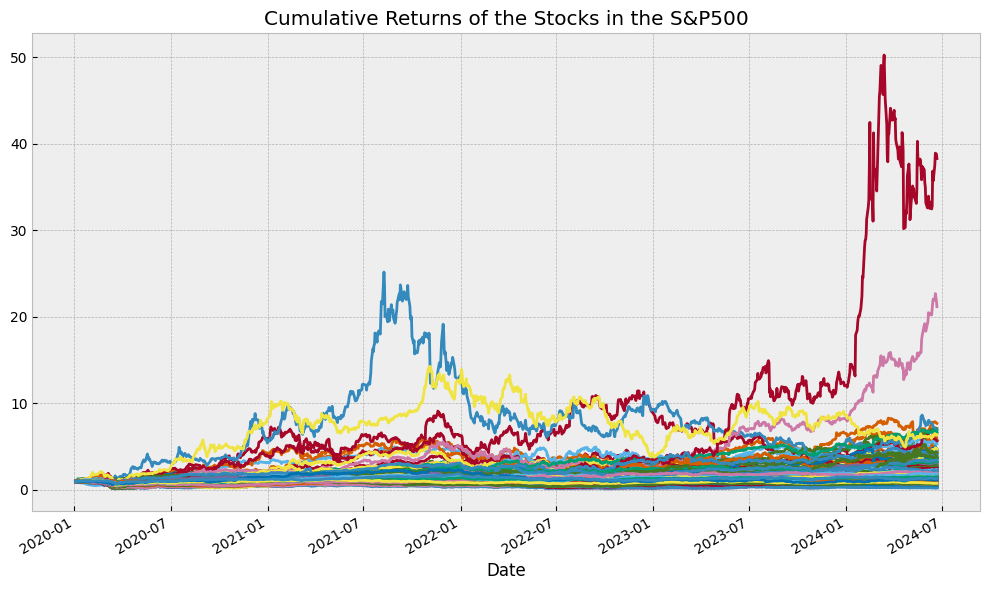

In [ ]:
# Plot the Cumulative Returns for the stocks in S&P 500 list
(rs.cumsum().apply(np.exp)).plot(legend=0, figsize=(10,6), grid=True, title='Cumulative Returns of the Stocks in the S&P500')
plt.tight_layout()
#plt.savefig('tmp.png')

In [ ]:
correlation_matrix = rs.corr()

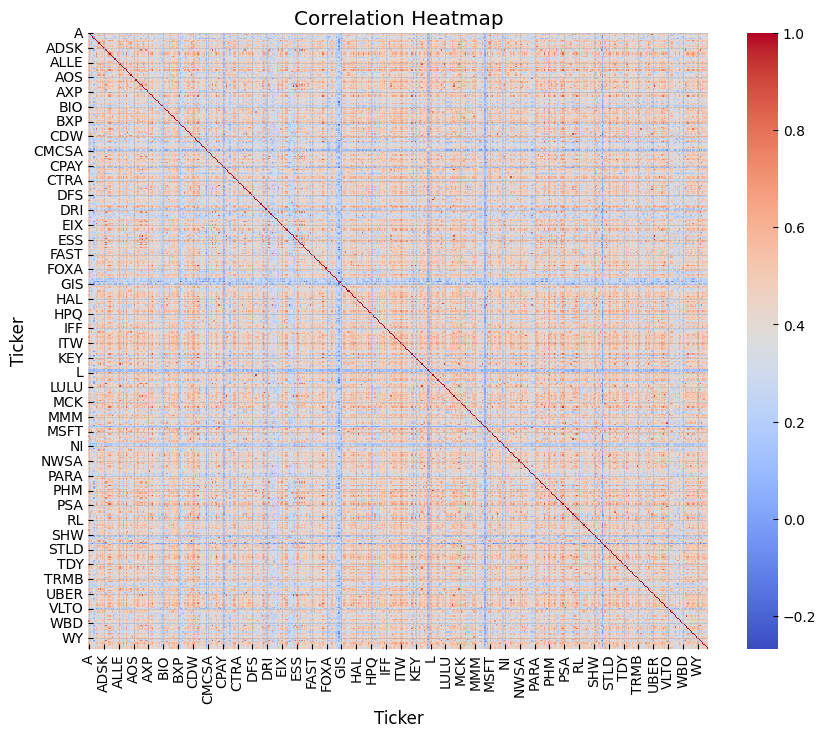

In [ ]:
# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Conduct PCA to check how principal components can explain the variation in stock price movement

In [ ]:
pca_eda = PCA(n_components = 20)

In [ ]:
#calculate variance ratios
pca_eda.fit(rs.fillna(0))
variance = pca_eda.explained_variance_ratio_
variance

array([0.41691317, 0.06338504, 0.04101417, 0.026201  , 0.0169505 ,
       0.01317575, 0.01203268, 0.00982458, 0.00938831, 0.00849582,
       0.00816164, 0.00738186, 0.00677586, 0.00648488, 0.00622681,
       0.00592006, 0.00571665, 0.00534761, 0.00499771, 0.00469469])

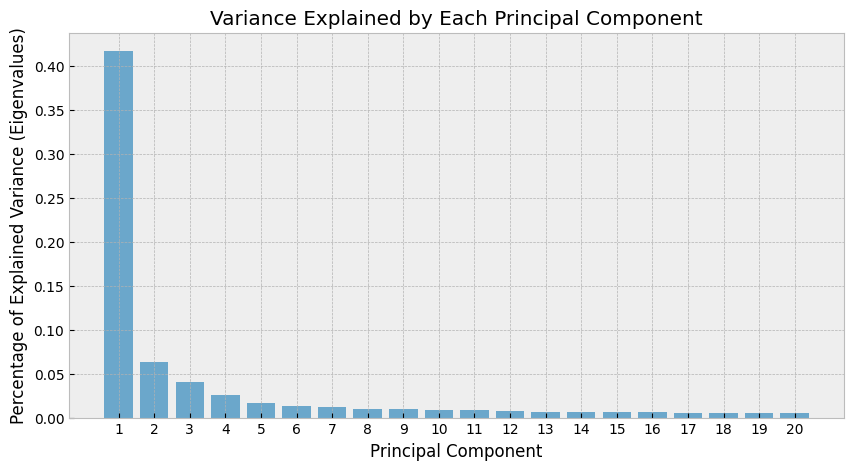

In [ ]:
# Plot the variance explained by each component
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(variance) + 1), variance, alpha=0.7, align='center')
plt.ylabel('Percentage of Explained Variance (Eigenvalues)')
plt.xlabel('Principal Component')
plt.title('Variance Explained by Each Principal Component')
plt.xticks(range(1, len(variance) + 1))  # Ensure x-axis is in integers
plt.grid(True)
plt.show()

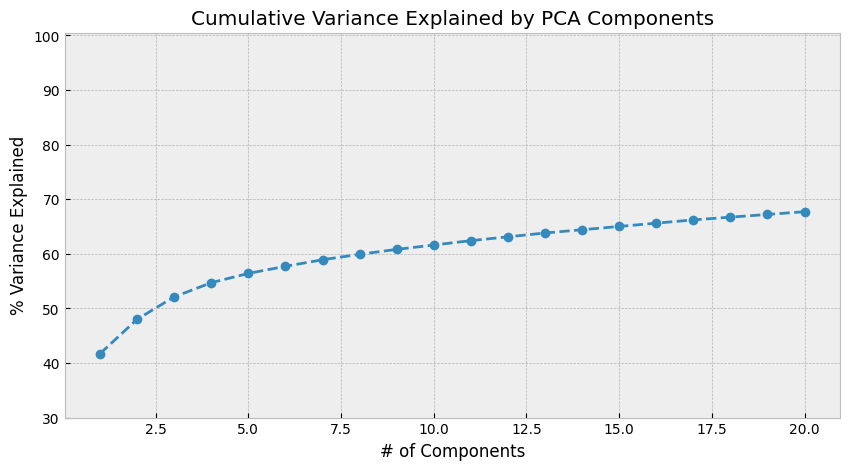

In [ ]:
# Cumulative sum of variance explained with [n] components
var = np.cumsum(np.round(variance, decimals=3) * 100)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(var) + 1), var, marker='o', linestyle='--')
plt.ylabel('% Variance Explained')
plt.xlabel('# of Components')
plt.title('Cumulative Variance Explained by PCA Components')
plt.ylim(30, 100.5)
plt.grid(True)
plt.show()

## Apply PCA to Stock Returns: Extract the First Principal Component

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(1).fit(rs.fillna(0))

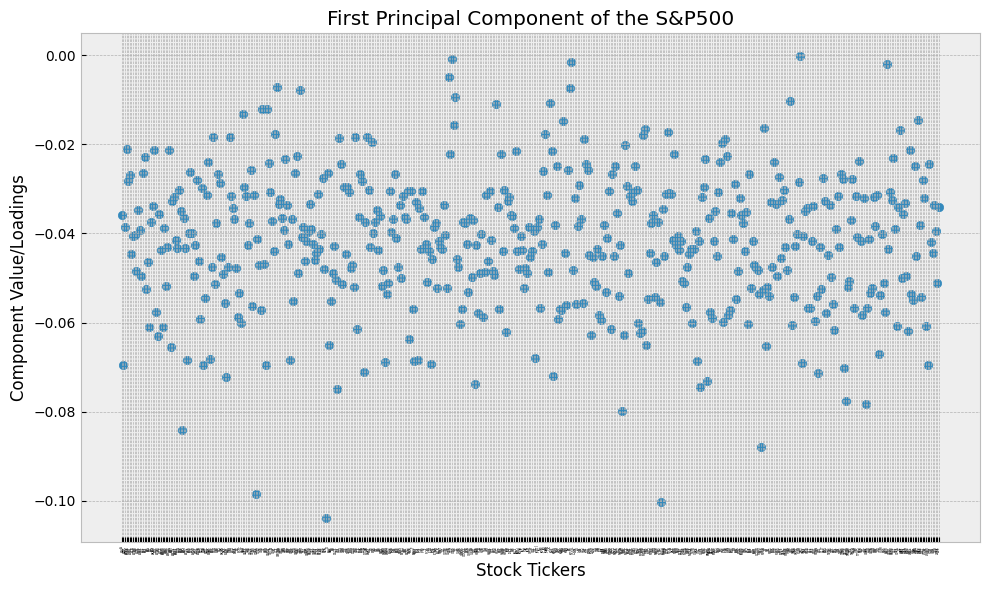

In [ ]:
pc1 = pd.Series(index=rs.columns, data=pca.components_[0])


# Plot as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pc1.index, pc1)
plt.xticks(rotation=90, fontsize=2)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.title('First Principal Component of the S&P500')
plt.xlabel('Stock Tickers')
plt.ylabel('Component Value/Loadings')
plt.tight_layout()
plt.show()

In [ ]:
# Show the component value for each stocks
pc1

Ticker
A      -0.035939
AAL    -0.069496
AAPL   -0.038551
ABBV   -0.021099
ABNB   -0.028220
          ...   
XYL    -0.044403
YUM    -0.033540
ZBH    -0.039546
ZBRA   -0.051207
ZTS    -0.034168
Length: 501, dtype: float64

# Reconstruct first component porfolio based on components' loadings
From the previous graph, we observe that most of the component values are negative due to the nature of PCA. To obtain the factor loadings (Beta), we need to multiply these values by -1. In contrast, if we were to use the covariance matrix as input, which omits temporal information, this adjustment would not be necessary.

<Axes: xlabel='Date'>

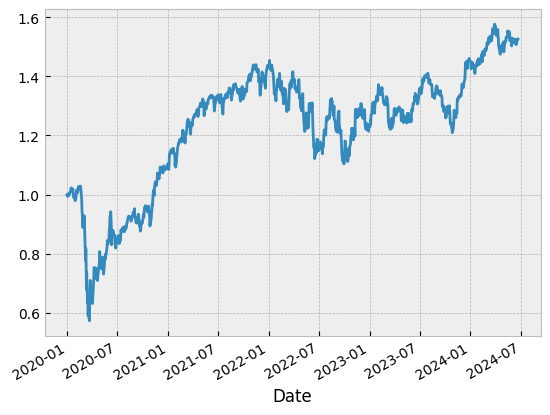

In [ ]:
# There are several ways to reconstruct the weights, in this study, i choose to use the one which can retain the direction or long/short information

weights = -pc1 / sum(abs(pc1)) # the reason why i use negative sign here is that, in this way, the loadings can have right economy meaning - the beta of a factor
myrs = (weights*rs).sum(1)
myrs.cumsum().apply(np.exp).plot()


#Alternative approach, make all the weights positive
##weights = abs(pc1)/sum(abs(pc1))

### Compare the Movement of First Component Portfolio with the S&P500 Index

In [ ]:
# Download SPY ETF data through Yahoo Finance API
prices = yf.download(['SPY'], start='2020-01-01')['Adj Close']

[*********************100%%**********************]  1 of 1 completed


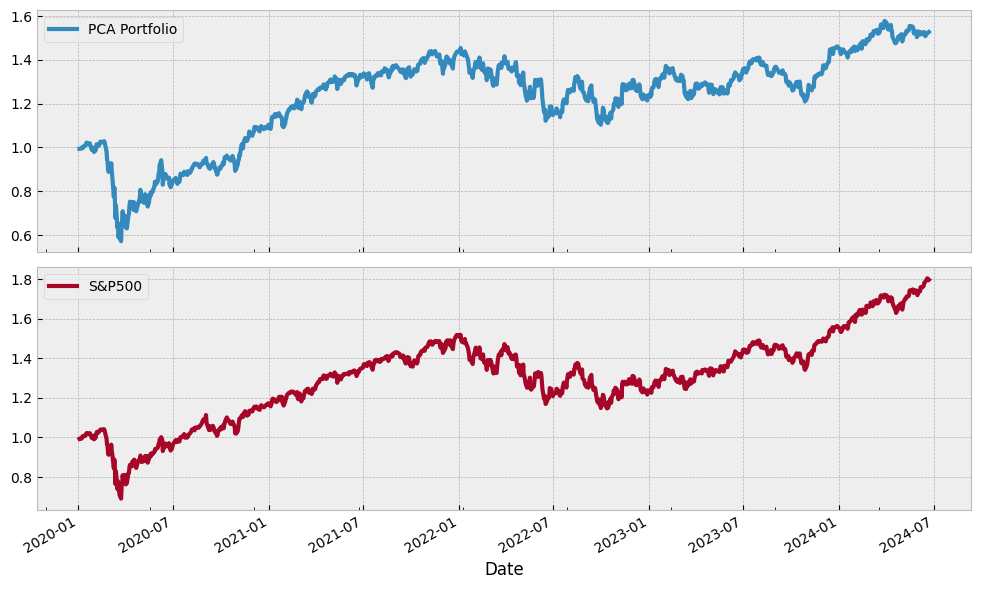

In [ ]:
# Compare the cumulative return of PC1 Portfolio and SPY
rs_df = pd.concat([myrs, prices.apply(np.log).diff(1)], axis =  1)
rs_df.columns = ["PCA Portfolio", "S&P500"]

rs_df.dropna().cumsum().apply(np.exp).plot(subplots=True, figsize=(10,6), grid=True, linewidth=3);
plt.tight_layout()
plt.savefig('tmp.png')

# Construct Portfolios through PCA filtering
Note: When interpreting PCA weights in an economic context, we need to multiply these weights by -1. Consequently, stocks with the most negative PCA weights have the highest beta to the implied factor, while those with the highest PCA weights have the lowest beta.<br>

In this study, I choose to construct the portfolio using stocks that are least sensitive or even negatively correlated to the PC1 implied factor.

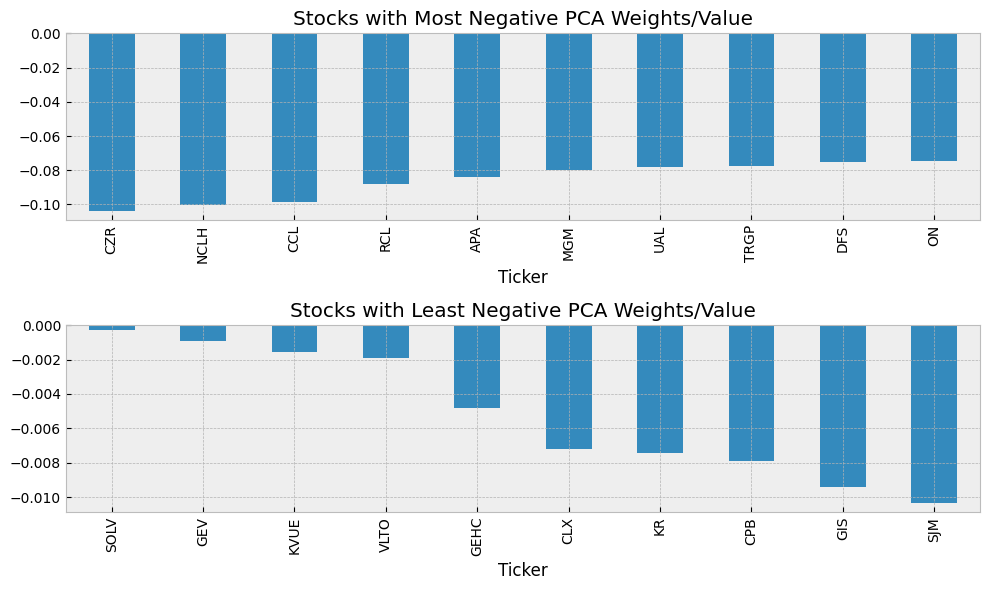

In [ ]:
# plot the stocks with top 10 and bottom 10 weights on the first principal components
fig, ax = plt.subplots(2,1, figsize=(10,6))
pc1.nsmallest(10).plot.bar(ax=ax[0], grid=True, title='Stocks with Most Negative PCA Weights/Value')
pc1.nlargest(10).plot.bar(ax=ax[1], grid=True, title='Stocks with Least Negative PCA Weights/Value')

plt.tight_layout()

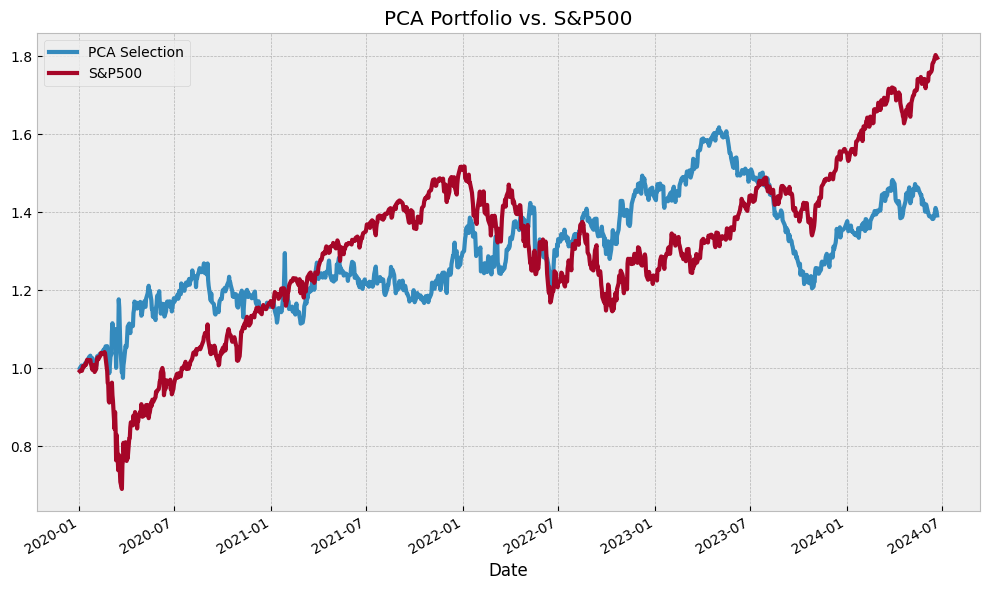

In [ ]:
# ws = [-1,]*10+[1,]*10
# myrs = (rs[list(pc1.nsmallest(10).index)+list(pc1.nlargest(10).index)]*ws).mean(1)
myrs = rs[pc1.nlargest(10).index].mean(1)
myrs.cumsum().apply(np.exp).plot(figsize=(15,5), grid=True, linewidth=3, title='PCA Portfolio vs. S&P500')
prices['2020':].apply(np.log).diff(1).cumsum().apply(np.exp).plot(figsize=(10,6), grid=True, linewidth=3)
plt.legend(['PCA Selection', 'S&P500'])

plt.tight_layout()
plt.savefig('tmp.png')

#Backtesing PCA suggested portfolios
When backtesting PCA-suggested portfolios, it is crucial to avoid look-ahead bias. To achieve this, I use data prior to 2022-01-01 to construct the PCA-suggested portfolios and data post-2022-01-01 to backtest the strategy.<br>

A better approach would be to rebalance using rolling windows. This involves continually updating the PCA-suggested portfolios by periodically recalculating the PCA on a rolling basis, which helps adapt to changing market conditions and maintain the strategy's validity over time. However, I will not tackle this in the current study, as it focuses solely on the "Machine Learning Approach to Finance Data." A thorough study incorporating rolling and rebalancing will be uploaded to the strategy backtesting section in the future.

## Getting the weights through PCA

In [ ]:
rs_2021=rs.loc[:'2021-12-31']
prices_2021=prices.loc[:'2021-12-31']
pca = PCA(1).fit(rs_2021.fillna(0))
pc1_2021 = pd.Series(index=rs.columns, data=pca.components_[0])

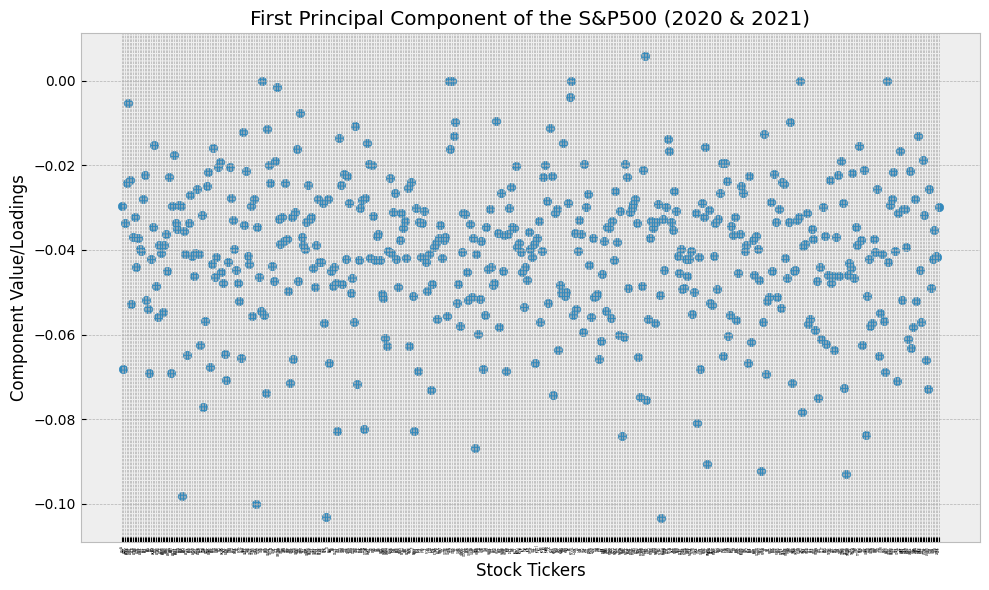

In [ ]:

# Plot as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pc1_2021.index, pc1_2021)
plt.xticks(rotation=90, fontsize=2)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.title('First Principal Component of the S&P500 (2020 & 2021)')
plt.xlabel('Stock Tickers')
plt.ylabel('Component Value/Loadings')
plt.tight_layout()
plt.show()

<Axes: xlabel='Date'>

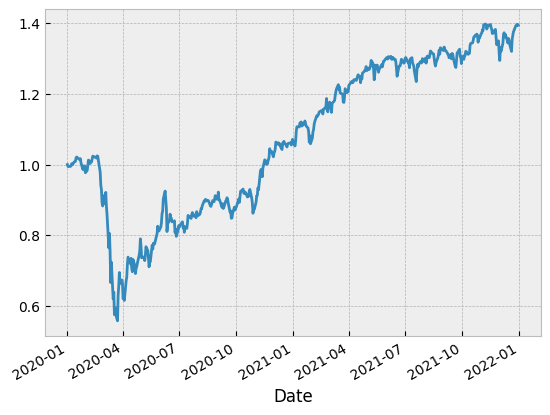

In [ ]:
weights_new = - pc1_2021/sum(abs(pc1_2021))
myrs_2021 = (weights_new*rs_2021).sum(1)
myrs_2021.cumsum().apply(np.exp).plot()

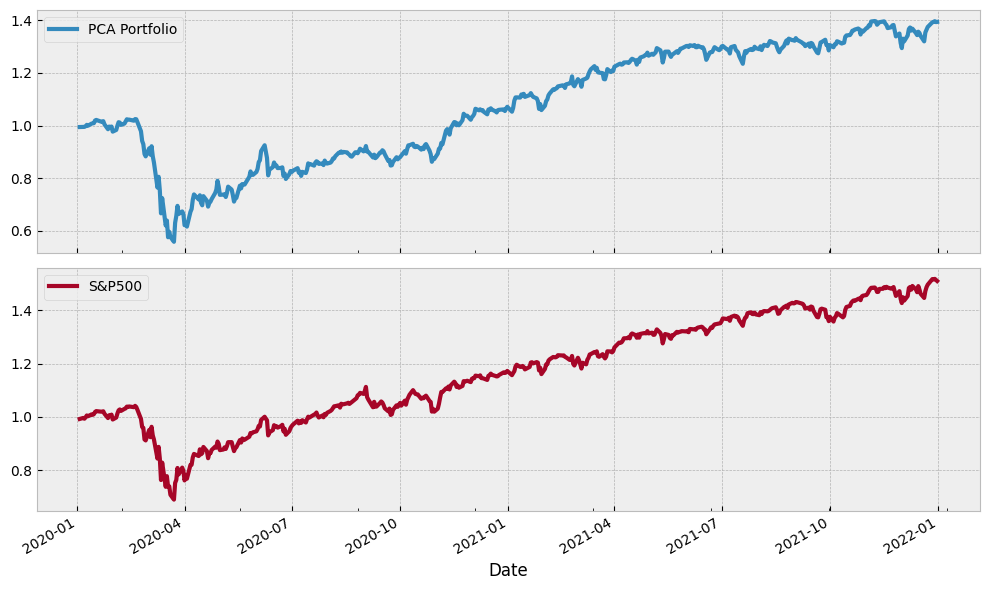

In [ ]:
# Plot the movement. note: this is not backtesting
rs_df_new = pd.concat([myrs_2021, prices_2021.apply(np.log).diff(1)], axis = 1)
rs_df_new.columns = ["PCA Portfolio", "S&P500"]
rs_df_new.dropna().cumsum().apply(np.exp).plot(subplots=True, figsize=(10,6), grid=True, linewidth=3);
plt.tight_layout()

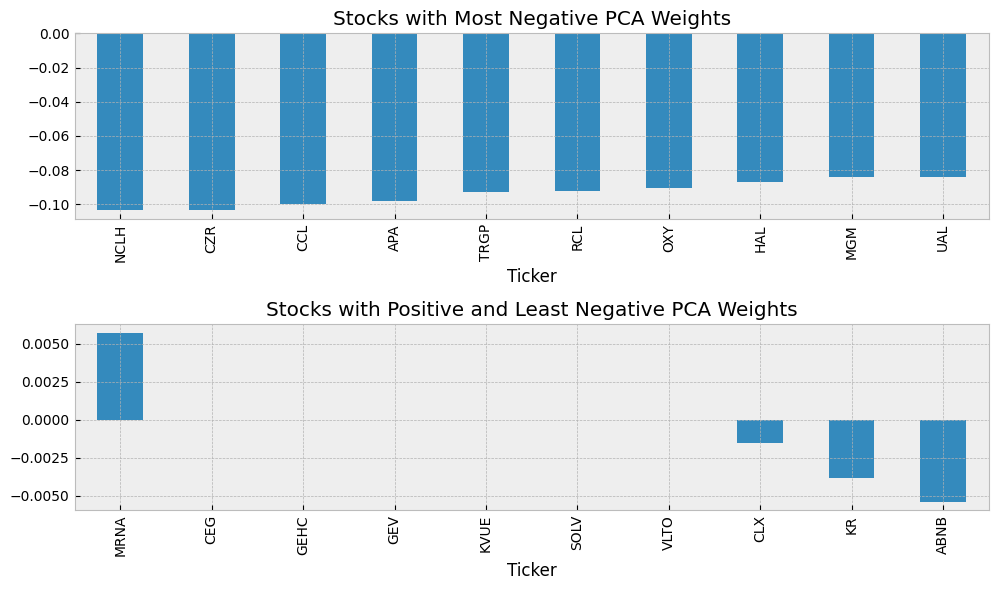

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
pc1_2021.nsmallest(10).plot.bar(ax=ax[0], grid=True, title='Stocks with Most Negative PCA Weights')
pc1_2021.nlargest(10).plot.bar(ax=ax[1], grid=True, title='Stocks with Positive and Least Negative PCA Weights')

plt.tight_layout()

## Backtesting

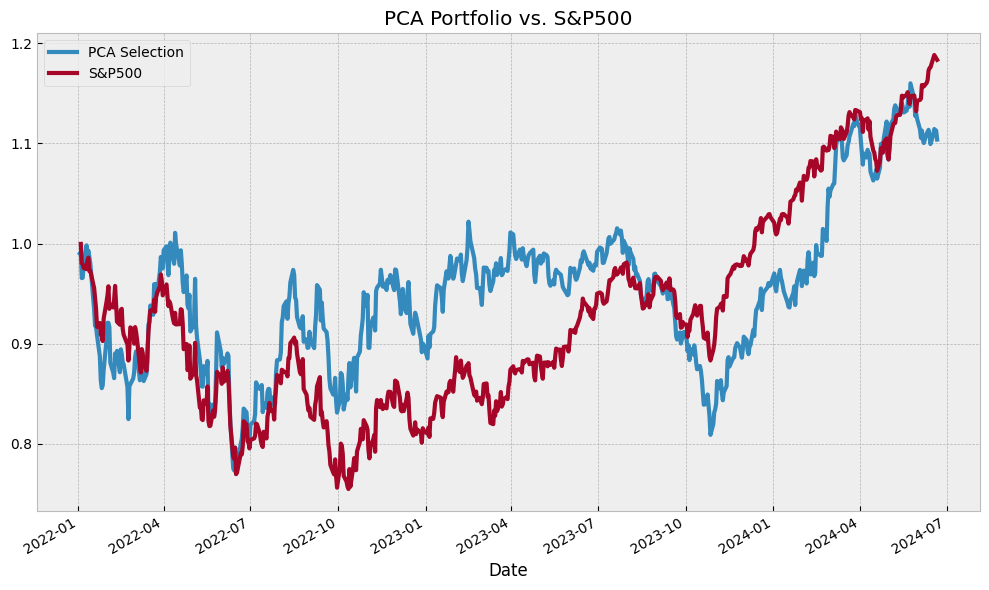

In [ ]:
# Plot the porfolio constisting of stocks with top 10 largest weights.
myrs = rs[pc1_2021.nlargest(10).index].mean(1)
myrs=myrs.loc['2022-01-01':]
myrs.cumsum().apply(np.exp).plot(figsize=(15,5), grid=True, linewidth=3, title='PCA Portfolio vs. S&P500')
prices['2022-01-01':].apply(np.log).diff(1).cumsum().apply(np.exp).plot(figsize=(10,6), grid=True, linewidth=3)
plt.legend(['PCA Selection', 'S&P500'])

plt.tight_layout()
plt.savefig('tmp.png')

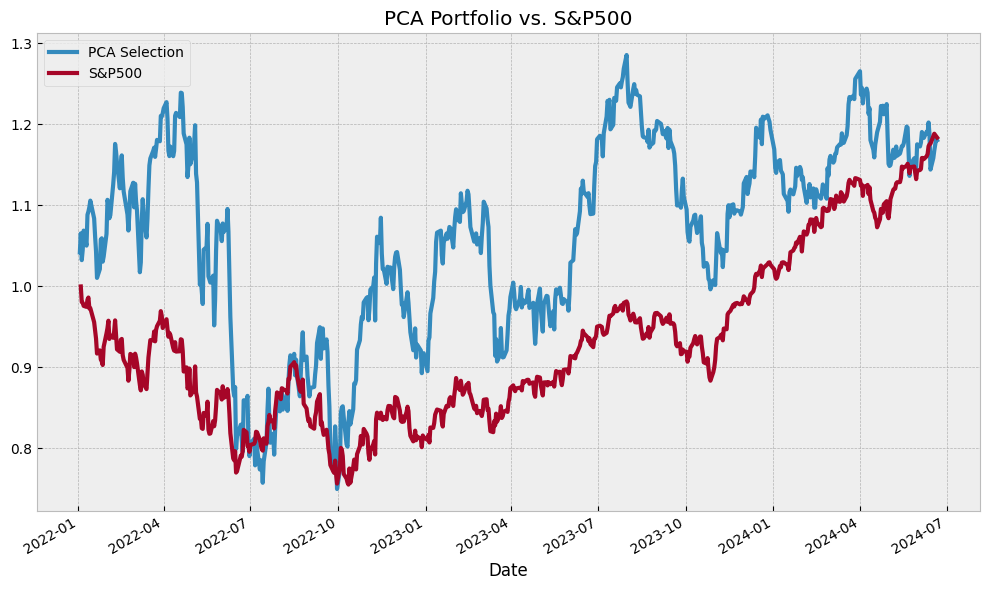

In [ ]:
# Plot the porfolio constisting of stocks with bottom 10 negative weights.
myrs = rs[pc1_2021.nsmallest(10).index].mean(1)
myrs=myrs.loc['2022-01-01':]
myrs.cumsum().apply(np.exp).plot(figsize=(15,5), grid=True, linewidth=3, title='PCA Portfolio vs. S&P500')
prices['2022-01-01':].apply(np.log).diff(1).cumsum().apply(np.exp).plot(figsize=(10,6), grid=True, linewidth=3)
plt.legend(['PCA Selection', 'S&P500'])

plt.tight_layout()
plt.savefig('pca_portfolio.pdf')

#Dicussion and Limitations

### Approaches to PCA in Stock Market Analysis

There are several methods to conduct Principal Component Analysis (PCA) to identify factors in the stock market, each with its own advantages and limitations. The choice of method depends on the specific goals of the analysis, such as capturing temporal information or focusing on explainability.

&nbsp;&nbsp;&nbsp;&nbsp;**Direct PCA on Multi-Stock Return Series:**

&nbsp;&nbsp;&nbsp;&nbsp;*Description:* Applying PCA directly to the multi-stock return series retains temporal information, allowing for the capture of time-varying relationships between stocks.

&nbsp;&nbsp;&nbsp;&nbsp;*Advantages:* Preserves temporal dynamics, useful for understanding how factors evolve over time.

&nbsp;&nbsp;&nbsp;&nbsp;*Disadvantages:* May introduce noise and inefficiencies in computation, as high-frequency variations can obscure underlying factors.

&nbsp;&nbsp;&nbsp;&nbsp;**PCA on Covariance Matrix of Stock Returns:**

&nbsp;&nbsp;&nbsp;&nbsp;*Description:* Calculate the covariance matrix of stock returns first, then apply PCA to this matrix. This approach focuses on the average co-movements of stocks over time.

&nbsp;&nbsp;&nbsp;&nbsp;*Advantages:* Reduces noise by averaging out temporal fluctuations, simplifies computations.

&nbsp;&nbsp;&nbsp;&nbsp;*Disadvantages:* Loses temporal information, as it only captures the static relationships between stocks.

&nbsp;&nbsp;&nbsp;&nbsp;**Dynamic PCA Using Lagged Covariance Matrices:**

&nbsp;&nbsp;&nbsp;&nbsp;*Description:* Dynamic PCA involves using several lagged covariance matrices to capture temporal dependencies in stock returns. This method accounts for the time-varying nature of stock relationships by incorporating information from multiple past time periods.

&nbsp;&nbsp;&nbsp;&nbsp;*Advantages:* Captures evolving relationships over time, providing insights into the dynamic behavior of stocks. It helps in understanding how past returns influence current factor structures, making it useful for time-series analysis.

&nbsp;&nbsp;&nbsp;&nbsp;*Disadvantages:* Computationally intensive due to the inclusion of multiple lagged matrices. Can be complex to implement and interpret, requiring careful management of lag length and data processing. Potential for overfitting if too many lags are included.


&nbsp;&nbsp;&nbsp;&nbsp;**Multiway PCA for Panel Data:**

&nbsp;&nbsp;&nbsp;&nbsp;*Description:* Multiway PCA extends traditional PCA to handle panel data, incorporating both time-series and cross-sectional information, such as financial ratios and factor loadings.

&nbsp;&nbsp;&nbsp;&nbsp;*Advantages:* Handles more complex data structures, provides deeper insights by combining multiple dimensions of data.

&nbsp;&nbsp;&nbsp;&nbsp;*Disadvantages:* More complex to implement, higher computational requirements.

&nbsp;&nbsp;&nbsp;&nbsp;**Dynamic Time Warping (DTW) Based Covariance for PCA:**

&nbsp;&nbsp;&nbsp;&nbsp;*Description:* Use DTW to align time series data, then calculate a covariance matrix based on the aligned series and apply PCA. This method adjusts for temporal misalignments before factor extraction.

&nbsp;&nbsp;&nbsp;&nbsp;*Advantages:* Captures true relationships by aligning time series, improves factor detection in the presence of temporal shifts.

&nbsp;&nbsp;&nbsp;&nbsp;*Disadvantages:* Computationally intensive, sensitive to noise and outliers.

&nbsp;&nbsp;&nbsp;&nbsp;**Rolling Window PCA:**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Description:* Apply PCA on rolling windows of the stock return series to capture how factors change over time.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Advantages:* Provides dynamic insights into factor evolution, useful for short-term analysis.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Disadvantages:* Window size selection can be challenging, potential for overfitting.

### The choice of PCA method depends on the specific task at hand:


&nbsp;&nbsp;&nbsp;&nbsp;**Capturing Temporal Information:** Direct PCA on return series, Rolling Window PCA, or Dynamic PCA are more suitable.

&nbsp;&nbsp;&nbsp;&nbsp;**Explaining Variability:** PCA on the covariance matrix or Multiway PCA can provide clearer insights into the underlying factors.

&nbsp;&nbsp;&nbsp;&nbsp;**Addressing Temporal Misalignments:** DTW-based Covariance for PCA is ideal for aligning and then analyzing time series data.

In conclusion, each PCA method has its strengths and weaknesses. The decision on which approach to use should be guided by the specific objectives of the analysis, whether it is more important to capture temporal dynamics or to focus on the explainability and stability of the factors.